<a href="https://colab.research.google.com/github/azimi99/ML-portfolio/blob/main/OnlineActorCritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPUT 653 Assignment 3 Alireza Azimi





In [ ]:
%reset -f
# Limit jupyter output size height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 10em; }</style>"))
# Import pytorch libraries
import torch as tor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
# Import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors

In [ ]:
# Let's begin by imlementing the environment of the agent
class DotReacher():
  '''
    Dot Reacher is a stationary environment with
    a continuous state space and a discrete action space
  '''
  def __init__(self):
    self.actions = [
        0, # LEFT
        1, # LEFT-UP
        2, # UP
        3, # RIGHT-UP
        4, # RIGHT
        5, # RIGHT-DOWN
        6, # DOWN
        7, # LEFT-DOWN
        8 # STAY
    ]
    self.reward = -0.01 # fixed reward signal
    self.B = 0.03 # travel distance

  def start(self):
    '''
      Selects start states with default random generator
      generator (tor.Generator): Pytorch generator

      Returns:
      start state tensor
    '''
    self.current_state = (2*tor.rand(1,2)-1)[0]
    return self.current_state
  def start_with_generator(self, generator):
    '''
      Selects start states with specified random generator
      generator (tor.Generator): Pytorch generator

      Returns:
      start state tensor
    '''
    self.current_state = (2*tor.rand(1,2, generator=generator)-1)[0]
    return self.current_state
  def isTerminal(self, state):
    '''
      Checkes if state is terminal
      state (tor.tensor): state value

      Returns:
      True or false depending on state
    '''
    return -0.2 <= state[0] <= 0.2 and -0.2 <= state[1] <= 0.2
  def step(self, action, state):
    '''
      Function that maps: (s,a) -> (s', r)
      action (int): action taken
      state (torch.tensor): state the action was taken

      Returns:
      Next state and reward
    '''
    state = state.clone()
    if action == 0: # LEFT
      state += tor.tensor([-1.0*self.B, 0])
    elif action == 1: # LEFT-UP
      state += 1/np.sqrt(2) * tor.tensor([-1.0 * self.B, self.B])
    elif action == 2: # UP
      state += tor.tensor([0, self.B])
    elif action == 3: # RIGHT-UP
      state += 1/np.sqrt(2) * tor.tensor([self.B, self.B])
    elif action == 4: # RIGHT
      state += tor.tensor([self.B, 0])
    elif action == 5: # RIGHT-DOWN
      state += 1/np.sqrt(2) * tor.tensor([self.B, -1*self.B])
    elif action == 6: # DOWN
      state += tor.tensor([0, -1*self.B])
    elif action == 7: # LEFT-DOWN
      state += 1/np.sqrt(2) * tor.tensor([-1*self.B, -1*self.B])
    elif action == 8: # STAY
      pass
    state = tor.clip(state, min=-1.0, max=1.0)
    return self.reward, state





In [ ]:
# Testing environment to make sure it's working correctly
env = DotReacher()
assert -1 <= env.start()[0] <= 1 and -1 <= env.start()[1] <= 1
assert -1 <= env.current_state[0] <= 1 and -1 <= env.current_state[1] <= 1
state = tor.tensor([0,0], dtype=tor.float64)
reward, current_state = env.step(0, state.clone())
assert reward == -0.01
assert tor.norm(current_state - tor.tensor([-0.03, 0])) < 0.01
reward, current_state = env.step(1, state.clone())
assert reward == -0.01
assert tor.norm(current_state - 1/np.sqrt(2)*tor.tensor([-0.03, 0.03])) < 0.01
reward, current_state = env.step(2, state.clone())
assert reward == -0.01
assert tor.norm(current_state - tor.tensor([0, 0.03])) < 0.01
reward, current_state = env.step(3, state.clone())
assert reward == -0.01
assert tor.norm(current_state - 1/np.sqrt(2) * tor.tensor([0.03, 0.03])) < 0.01
reward, current_state = env.step(4, state.clone())
assert reward == -0.01
assert tor.norm(current_state - tor.tensor([0.03, 0])) < 0.01
reward, current_state = env.step(5, state.clone())
assert reward == -0.01
assert tor.norm(current_state - 1/np.sqrt(2) * tor.tensor([0.03, -0.03])) < 0.01
reward, current_state = env.step(6, state.clone())
assert reward == -0.01
assert tor.norm(current_state - tor.tensor([0, -0.03])) < 0.01
reward, current_state = env.step(7, state.clone())
assert reward == -0.01
assert tor.norm(current_state - 1/np.sqrt(2) * tor.tensor([-0.03, -0.03])) < 0.01
reward, current_state = env.step(8, state.clone())
assert reward == -0.01
assert tor.norm(current_state - 1/np.sqrt(2) * tor.tensor([0, 0])) < 0.01
state = tor.tensor([0.99,0.99], dtype=tor.float64)
reward, current_state = env.step(3, state.clone())
assert reward == -0.01
assert tor.norm(current_state - tor.tensor([1, 1])) < 0.01
state = tor.tensor([-0.99,-0.99], dtype=tor.float64)
reward, current_state = env.step(7, state.clone())
assert reward == -0.01
assert tor.norm(current_state - tor.tensor([-1, -1])) < 0.01
assert env.isTerminal(tor.tensor([0,0.5])) == False
assert env.isTerminal(tor.tensor([0.,0.]))

In [ ]:
# Learning Rates
LR_POLICY = 0.001
LR_VALUE = 0.002

In [ ]:
def plot_trajectories(trajectories):
  '''
    Plots trajectories with specified style
    generator (tor.Generator): Pytorch generator
  '''
  fig, ax = plt.subplots(figsize=(10,10))
  list_of_colors = ['brown', 'blue', 'darkred', 'green', 'red', 'purple' , 'pink', 'gray', 'olive', 'cyan']
  for index, traj in enumerate(trajectories):
    if len(traj) > 0:
      colorfade = colors.to_rgb(list_of_colors[index%10]) + (0.0,)
      episode_color = colors.LinearSegmentedColormap.from_list('my',[colorfade, list_of_colors[index%10]])
      x,y = [i[0] for i in traj], [j[1] for j in traj]
      points = np.vstack((x, y)).T.reshape(-1, 1, 2)
      segments = np.hstack((points[:-1], points[1:]))
      alphas = np.linspace(0, 1, len(x) - 1)
      lc = LineCollection(segments, array=alphas, cmap=episode_color, lw=1)
      line = ax.add_collection(lc)
  ax.autoscale()
  plt.grid(True)
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  plt.show()

# Part (a)

In [ ]:
'''
Signle run of online actor critic agent
Seed set to 1
'''
tor.manual_seed(10) # setting random seed
# Actor
PolicyNet = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 9)
)
# Initialize weights and biases of the output layer to zero
nn.init.zeros_(PolicyNet[-1].weight)
nn.init.zeros_(PolicyNet[-1].bias)

# Critic
ValueNet = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,1)
)

# Specify optimizers
policy_optim = optim.Adam(PolicyNet.parameters(), lr=LR_POLICY)
value_optim = optim.Adam(ValueNet.parameters(), lr=LR_VALUE)

# One-Step Actor Critic Algorithm
steps = 0
last_episode_steps = steps
episode = 1
dotReacher = DotReacher()
trajectories = []
last_30_trajectories = []
while steps < 40000:
  state = dotReacher.start()
  if dotReacher.isTerminal(state):
    steps += 1
  episode_traj = []
  while not dotReacher.isTerminal(state) and steps < 40000:
    # sample action
    policy_logits = PolicyNet(state)
    policy_dist = F.softmax(policy_logits, dim=-1)
    action = tor.multinomial(policy_dist, 1).item()
    reward, next_state = dotReacher.step(action, state)
    current_value = ValueNet(state)
    next_value = ValueNet(next_state)
    # TD error
    delta = reward + next_value.data - current_value.data if not dotReacher.isTerminal(next_state)\
     else reward - current_value.data
    estimator_policy = -tor.log(policy_dist[action]) * delta
    estimator_val = -current_value * delta
    # update step
    value_optim.zero_grad()
    estimator_val.backward()
    value_optim.step()
    policy_optim.zero_grad()
    estimator_policy.backward()
    policy_optim.step()
    if episode <= 10 or (570 <= episode <= 599):
      episode_traj.append(state)
    state = next_state
    steps += 1
    if steps == 30000:
      print("--------- 30K Episode Threshold Achieved ----------")
  if episode <= 10:
    trajectories.append(episode_traj)
  elif 570 <= episode <= 599:
    last_30_trajectories.append(episode_traj)
  print(f"Episode #{episode}: {steps - last_episode_steps} steps")
  episode += 1
  last_episode_steps = steps
print(f"Done training. Total Episodes: {episode}")

Episode #1: 732 steps
Episode #2: 1196 steps
Episode #3: 626 steps
Episode #4: 134 steps
Episode #5: 74 steps
Episode #6: 1725 steps
Episode #7: 197 steps
Episode #8: 117 steps
Episode #9: 308 steps
Episode #10: 44 steps
Episode #11: 615 steps
Episode #12: 11 steps
Episode #13: 1089 steps
Episode #14: 111 steps
Episode #15: 636 steps
Episode #16: 136 steps
Episode #17: 774 steps
Episode #18: 61 steps
Episode #19: 496 steps
Episode #20: 31 steps
Episode #21: 485 steps
Episode #22: 3 steps
Episode #23: 596 steps
Episode #24: 4 steps
Episode #25: 195 steps
Episode #26: 99 steps
Episode #27: 34 steps
Episode #28: 624 steps
Episode #29: 591 steps
Episode #30: 51 steps
Episode #31: 60 steps
Episode #32: 464 steps
Episode #33: 403 steps
Episode #34: 24 steps
Episode #35: 388 steps
Episode #36: 57 steps
Episode #37: 50 steps
Episode #38: 47 steps
Episode #39: 574 steps
Episode #40: 345 steps
Episode #41: 1 steps
Episode #42: 275 steps
Episode #43: 505 steps
Episode #44: 1 steps
Episode #45: 55

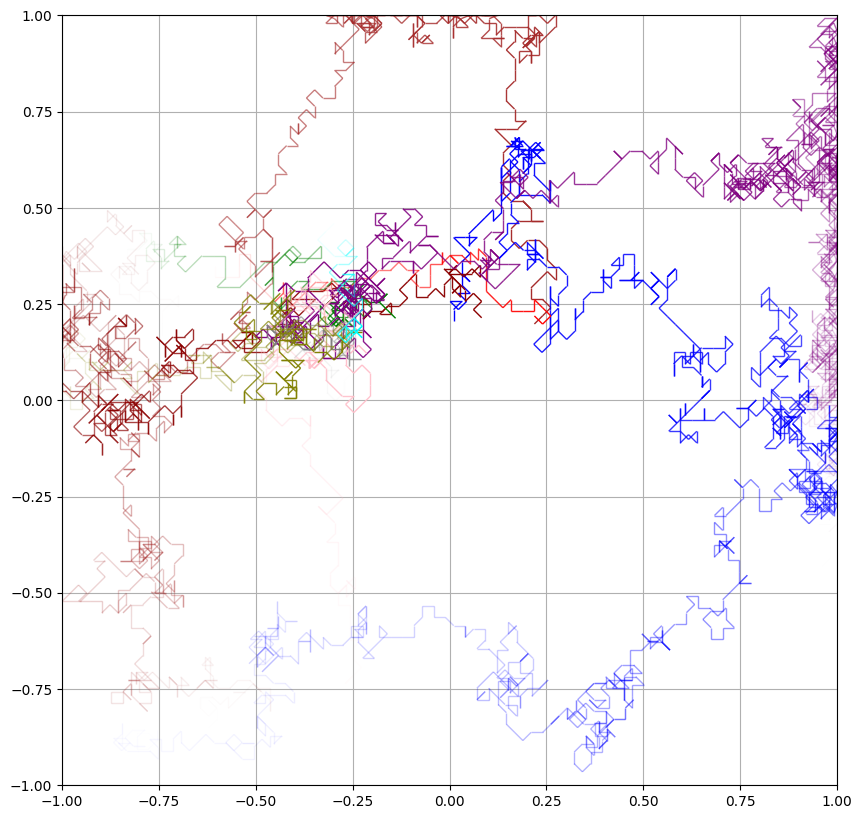

In [ ]:
plot_trajectories(trajectories)

# Part (b)

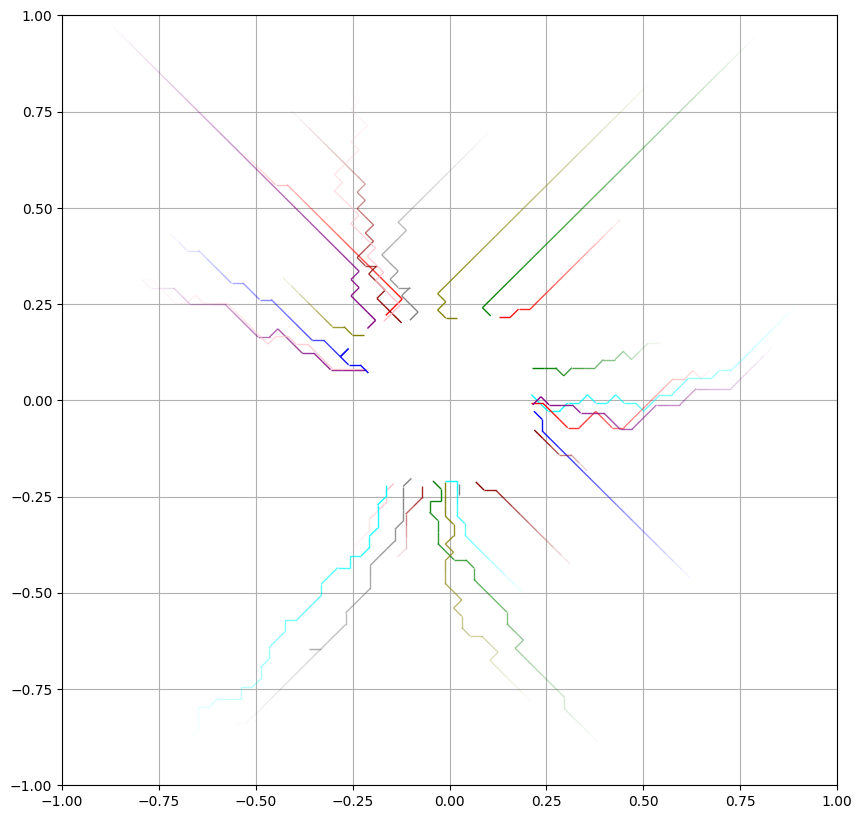

In [ ]:
plot_trajectories(last_30_trajectories)

# Part (c)

In [ ]:
# One-Step Actor Critic Algorithm
def run_experiment(seed):
  tor.manual_seed(seed) # setting random seed
  # Actor
  PolicyNet = nn.Sequential(
              nn.Linear(2, 10),
              nn.ReLU(),
              nn.Linear(10, 10),
              nn.ReLU(),
              nn.Linear(10, 9)
  )
  # Initialize weights and biases of the output layer to zero
  nn.init.zeros_(PolicyNet[-1].weight)
  nn.init.zeros_(PolicyNet[-1].bias)

  # Critic
  ValueNet = nn.Sequential(
      nn.Linear(2, 10),
      nn.ReLU(),
      nn.Linear(10,10),
      nn.ReLU(),
      nn.Linear(10,1)
  )

  # Specify optimizers
  policy_optim = optim.Adam(PolicyNet.parameters(), lr=LR_POLICY)
  value_optim = optim.Adam(ValueNet.parameters(), lr=LR_VALUE)

  # One-Step Actor Critic Algorithm
  steps = 0
  last_episode_steps = steps
  episode = 1
  dotReacher = DotReacher()
  run_results = []
  generator = tor.Generator().manual_seed(0)
  while steps < 40000:
    state = dotReacher.start_with_generator(generator) # using generator to ensure same sequence of start states
    if dotReacher.isTerminal(state):
      steps += 1
    while not dotReacher.isTerminal(state) and steps < 40000:
      # sample action
      policy_logits = PolicyNet(state)
      policy_dist = F.softmax(policy_logits, dim=-1)
      action = tor.multinomial(policy_dist, 1).item()
      reward, next_state = dotReacher.step(action, state)
      current_value = ValueNet(state)
      next_value = ValueNet(next_state)
      # TD error
      delta = reward + next_value.data - current_value.data if not dotReacher.isTerminal(next_state)\
      else reward - current_value.data
      estimator_policy = -tor.log(policy_dist[action]) * delta
      estimator_val = -current_value * delta
      # update step
      value_optim.zero_grad()
      estimator_val.backward()
      value_optim.step()
      policy_optim.zero_grad()
      estimator_policy.backward()
      policy_optim.step()
      state = next_state
      steps += 1
    episode += 1
    run_results.append(steps - last_episode_steps)
    last_episode_steps = steps
  print(f"Done training. Run: {s}. Episode count: {episode}. Steps: {steps}")
  return run_results

seeds = list(range(1,11)) # 10 seed values
runs = []
for s in seeds:
  run_results = run_experiment(s)
  runs.append(run_results)




Done training. Run: 1. Episode count: 1087. Steps: 40000
Done training. Run: 2. Episode count: 1649. Steps: 40000
Done training. Run: 3. Episode count: 1793. Steps: 40000
Done training. Run: 4. Episode count: 1264. Steps: 40000
Done training. Run: 5. Episode count: 1698. Steps: 40000
Done training. Run: 6. Episode count: 1767. Steps: 40000
Done training. Run: 7. Episode count: 1670. Steps: 40000
Done training. Run: 8. Episode count: 1091. Steps: 40000
Done training. Run: 9. Episode count: 1576. Steps: 40000
Done training. Run: 10. Episode count: 1426. Steps: 40000


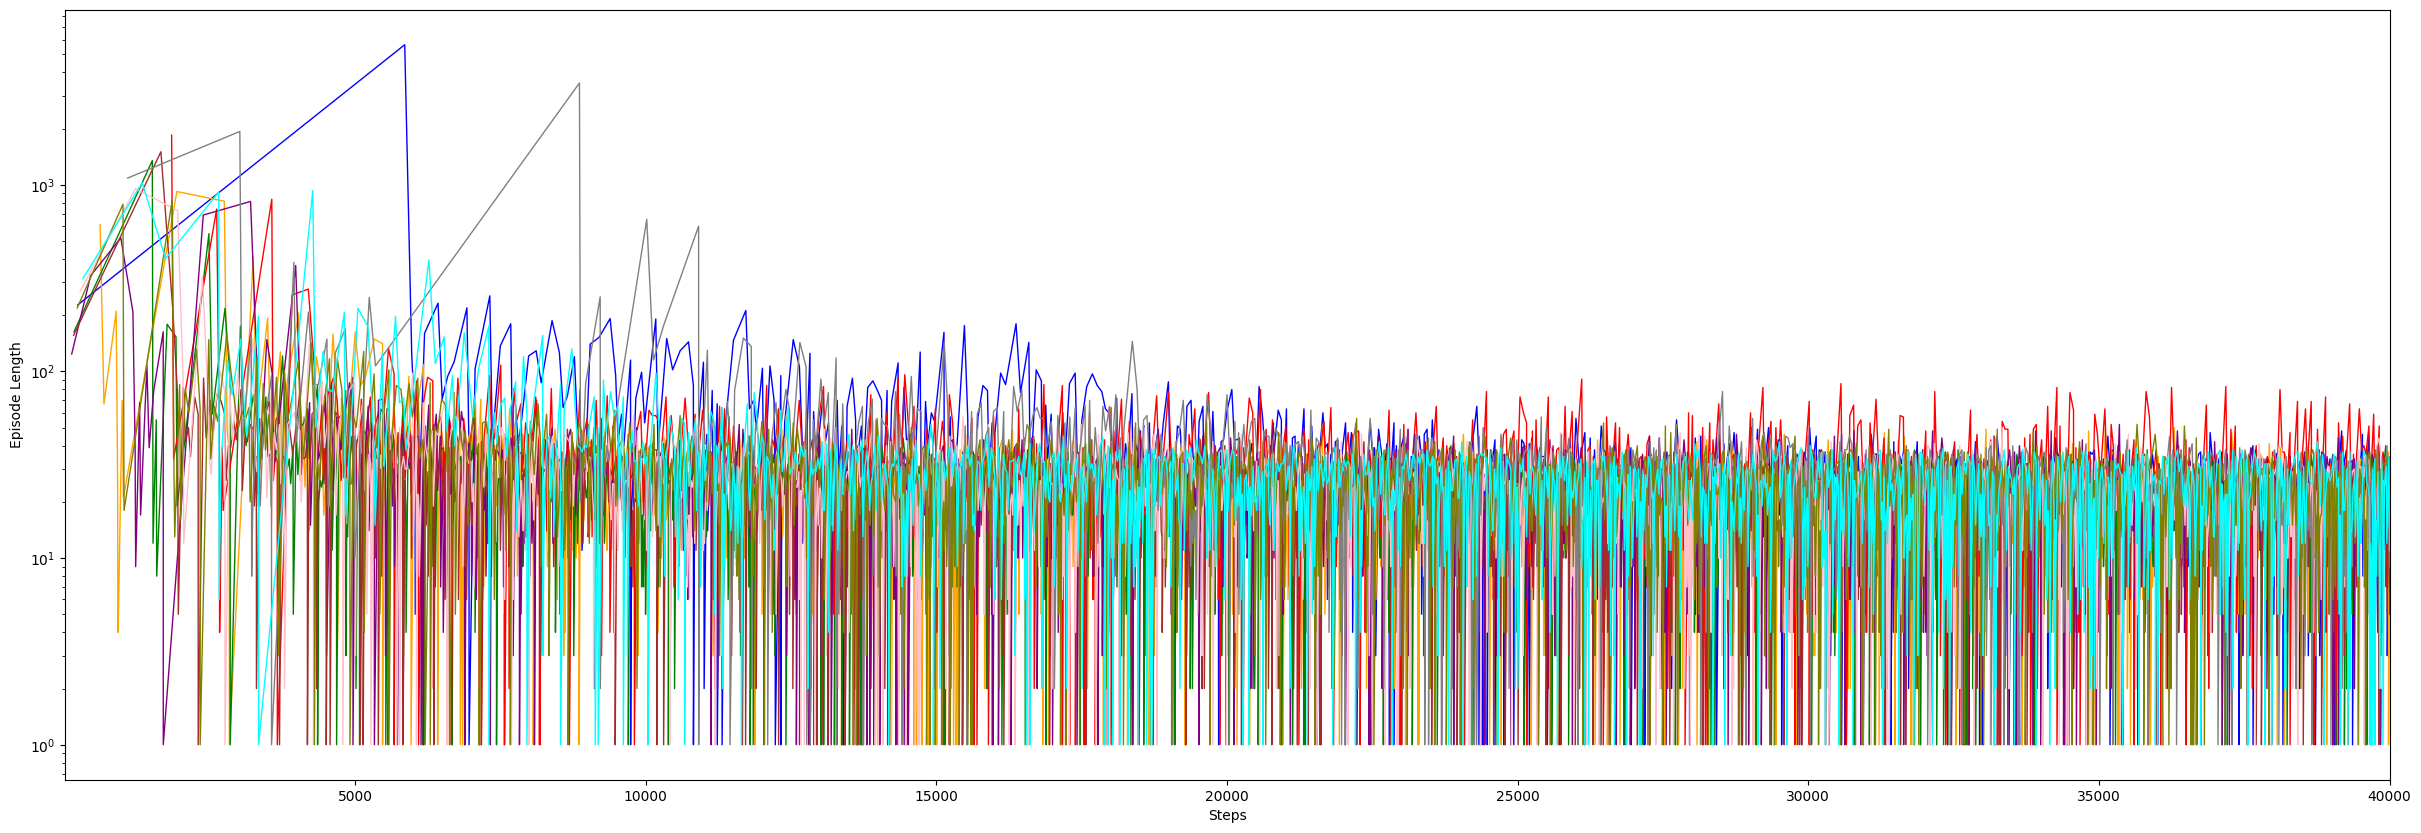

In [ ]:
colors_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
plt.figure(figsize=(30,10))
for index, run in enumerate(runs):
  x = np.cumsum(run)
  plt.plot(x, run, linewidth=1, color=colors_list[index])
plt.xlim(1, 40000)
plt.yscale('log')
plt.ylabel("Episode Length")
plt.xlabel("Steps")
plt.show()